# Introduction

This file will show us the ground truth that Ernest Provided in Matlab. Hopefully we can automate it a bit futher than this:

Previously we had mentioned about the ability for us to work with expectation across paths. This is a general case of the approach that Ernest
showed us in the previous meeting. 
Let us begin with:
$$
\begin{align*}
P(\text{error} | \Delta) &= \sum_{\rho\in \mathcal{P}} P(\epsilon , \rho | \Delta)\\
    &=\sum_{\rho\in \mathcal{P}} P(\epsilon | \rho , \Delta)P(\rho | \Delta)\\
    &=\sum_{\rho\in \mathcal{P}} P(\epsilon | \rho , \Delta)P_\Delta(\rho)\\
    &=\mathbb{E}\left[P(\epsilon | \rho , \Delta)\right]\\
\end{align*}
$$

Alas we obtain an expection of error $\epsilon$ over all the possible paths $\rho$. 

Let's expand each term for binary hypothesis testing as follows:
$$
\begin{align}
P(\epsilon | \rho, \Delta) &= P(\epsilon_{I} | \rho, \Delta) + P(\epsilon_{II} | \rho, \Delta)\\
    &= P(\hat{H} = 0 , H^*=1| \rho, \Delta) + P(\hat{H} = 1 , H^*=0| \rho, \Delta)\\
\end{align}
$$

A critical observation to be made here is that $\hat{H}|\rho \perp H^*|\rho$. This is because at the moment that we have observed our path $\rho$ the decision function collapases and becomes completely determined and independent of the hypothesis. 
Furthermore, the probability of selecting a hypothesis is such that $P(\hat{H}=i) \in \{0,1\}$. We thus end up with 
$$
\begin{align}
P(\epsilon|\rho,\Delta) &= P(\hat{H} = 0 | \rho, \Delta) P(H^* = 1 | \rho, \Delta) + P(\hat{H} = 1 | \rho, \Delta) P(H^* = 0 | \rho, \Delta)\\
    &= P(\hat{H} = 0 | \rho, \Delta) P(H^* = 1 | \rho, \Delta) + P(\hat{H} = 1 | \rho, \Delta) P(H^* = 0 | \rho, \Delta)\\
    &= P(\hat{H} = i | \rho, \Delta) P(H^* = j | \rho, \Delta) \\
    &= P(H^* = j | \rho, \Delta) \\
\end{align}
$$
Where only one term will be non-zero, the one where $P(\hat{H}|\rho, \Delta) = 1$
Where $j$ must be such $j\neq i$



WIth Ernest's Derivation we have:

$$
\begin{align*}
P(\epsilon| \rho, \Delta) &= P(H^* = j | \rho, \Delta) =\frac{P(H^*=j, \rho|\Delta)}{P(\rho | \Delta)}\\
    &=\frac{P(\rho|H^*=j,\Delta)P(H^*=j|\Delta)}{P(\rho | \Delta)}\\
    &=\frac{P^{(j)}_\Delta(\rho)\frac{1}{|\mathcal{H}|}}{P(\rho | \Delta)}
\end{align*}
$$

Notice that the only stochasticity in this system comes from the prior for the hypotheses $\{\mathcal{H}_i\}^N$

**ACTUALLY** I think this is not quite correct. The probability of observing a path $\rho$ changes as the chain evolves.

Then for the numerator

$$
\begin{align*}
P(H^* = j, \rho| \Delta) &= P(\rho | H^* = j, \Delta)\frac{1}{|\mathcal{H}|}\\
    &= P(S_1 = 0, S_0 = 0 | H^* = j , \Delta)\frac{1}{|\mathcal{H}|}\\
    &= P(S_1 = 0| S_0 = 0 , H^* = j , \Delta)P(S_0 = 0 | H^* = j, \Delta)\frac{1}{|\mathcal{H}|}\\
    &= P(S_1 = 0| S_0 = 0 , H^* = j , \Delta)1\frac{1}{|\mathcal{H}|}\\
\end{align*}
$$

Okay so we can go back to the way $\rho$ changes as the chain evolves. For now, we can simplify the denum as :

$$
\begin{align*}
P(\rho|\Delta) &= P(S_1 = 0 , S_0 = 0 | \Delta)\\
    &= \sum_{i\in|\mathcal{H}|} P(S_1 = 0, S_0 = 0 , H_i| \Delta)\\
    &= \sum_{i\in|\mathcal{H}|} P(S_1 = 0, S_0 = 0|H_i,\Delta)P(H_i|\Delta)\\
    &= \sum_{i\in|\mathcal{H}|} P(S_1 = 0| S_0 = 0,H_i,\Delta)P(S_0 = 0|H_i,\Delta)\frac{1}{|H_i|}\\
    &= \sum_{i\in|\mathcal{H}|} P(S_1 = 0| S_0 = 0,H_i,\Delta)1\frac{1}{|H_i|}\\
\end{align*}
$$

Then In that we case for when preference is for $\mathcal{H}_1$.

$$
P(\epsilon | \rho, \Delta) = \frac{P(S_1 = 0| S_0 = 0 , H^* = 2 , \Delta)}{\sum_i P(S_1 = 0| S_0 = 0,H_i,\Delta)}
$$
$$
P(\epsilon | \rho, \Delta) = \frac{P^j_\Delta(S_1 = 0| S_0 = 0)}{\sum P^i_\Delta(S_1 = 0| S_0 = 0)}
$$



Now here is where i am not entirely sure about my derivation. 

Tying it all together we have 

$$
\begin{align}
P(\epsilon| \Delta) &= \mathbb{E}\left[P(\epsilon|p,\Delta)\right]\\
    &= \mathbb{E}\left[\frac{P^{(j)}_\Delta(\rho)\frac{1}{|\mathcal{H}|}}{P(\rho | \Delta)}\right]
\end{align}
$$

## Lets Generalize this a bit

We want to start with 

$$
\begin{align}
P(\epsilon | \Rho, \Delta) =\frac{P^{(j)}_\Delta(\rho)\frac{1}{|\mathcal{H}|}}{P(\rho | \Delta)}
\end{align}
$$

then use this for a path $\rho$ of $n$ states. See what is the error probability that we get for this particular path. 
From the fact that decision function collapses to deterministic once a path is observed

We write

# Numerical Experiments

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import datetime
import argparse
from sklearn.metrics import roc_curve
from math import factorial
from scipy.linalg import expm
import sp_sims
from sp_sims.simulators.stochasticprocesses import *
from sp_sims.statistics.statistics import *
from sp_sims.estimators.algos import *
from IPython.display import clear_output
from sp_sims.sanitycheck.truebirthdeath import *
#from sp_sims.utils.utils import *
import random
from tqdm.notebook import tqdm
from time import sleep
import time

In [2]:
import importlib
importlib.reload(sp_sims.simulators.stochasticprocesses)
importlib.reload(sp_sims.statistics.statistics)

<module 'sp_sims.statistics.statistics' from '/Users/rac716/Research/RL_RateOptimization/sp_sims/statistics/statistics.py'>

In [3]:
%load_ext autoreload
%autoreload 2

## Prepping

In [4]:
# We may change args here:
class Args:
  xres = 100
  length = 3000# Number of transitions in continuous chain 
  state_limit = 1#Inclusive
  init_state = 0
  num_samples =2
  detection_guesses =1000
args = Args()

In [7]:
# Some Util Functions
def take_a_guess(tape, p0, p1):
    num = 0
    denum = 0
    # num = 1
    # denum = 1
    for i in range(len(tape)-1):
        from_state = tape[i]
        to_state = tape[i+1]
        # num  *= p0[from_state,to_state]
        # denum *= p1[from_state,to_state]
        num += -np.log(p0[from_state,to_state])
        denum += -np.log(p1[from_state,to_state])

    return 0 if num > denum else 1
def return_ls(tape, p0, p1):
    num = 1
    denum = 1
    for i in range(len(tape)-1):
        from_state = tape[i]
        to_state = tape[i+1]
        num  *= p0[from_state,to_state]
        denum *= p1[from_state,to_state]
    return num,denum
def stats_for_single_22paths(sts,hts,samp_rate, p0s, p1s, path = [0,0]):
    # Take all Paths 
    # This count how many i->j transitiosn per hypothesis are encountered
    hyp_counts = np.zeros(2) # 2 For 2 number of hypothesis
    # Dice them for sampling rates
    for i,p in enumerate(sts):
        idx_true_hyp = true_values[i]
        sampled_tape = quick_sample(samp_rate, sts[i],hts[i])

        count = ((tmpSampTape[:-1] == path[0]) & (tmpSampTape[1] == path[1])).sum()
        hyp_counts[idx_true_hyp] += count

    return hyp_counts


In [6]:
# Some Setup 
#rates0 = {"lam": 2/10,"mu":4/10}
#rates1 = {"lam": 100/10,"mu":120/10}
np.random.seed(int(time.time()))
rates0 = {"lam": 1,"mu":1.5}
rates1 = {"lam": 0.9,"mu":1.1}
rates = [rates0,rates1]
samp_rates = np.logspace(-3,5,args.xres, base=2)
tgm0 = np.array([[-rates0['lam'],rates0['lam']],[rates0['mu'],-rates0['mu']]])
tgm1 = np.array([[-rates1['lam'],rates1['lam']],[rates1['mu'],-rates1['mu']]])


hts, sts = ([],[])
last_times  = []
true_values = np.random.choice(2,args.detection_guesses)
# Generate The Tapes
for i in range(args.detection_guesses):
    roe = RaceOfExponentials(args.length,rates[true_values[i]],state_limit=args.state_limit)
    holdTimes_tape, state_tape = roe.generate_history(args.init_state)
    hts.append(holdTimes_tape);
    sts.append(state_tape)
    last_times.append(np.cumsum(holdTimes_tape)[-1])


In [7]:
# Preparation of True Probabilities
true_p0s = []
true_p1s = []
fixed_guesses = np.ones((len(samp_rates), args.detection_guesses))
# Crete all the *known* probability functions.
for srIdx, cur_samp_rate in enumerate(samp_rates):
    true_p0s.append(expm(tgm0*(1/cur_samp_rate)))
    true_p1s.append(expm(tgm1*(1/cur_samp_rate)))

## Sampling of Paths

## Quick Sample

In [8]:
########################################
# Generation
########################################
base_samp_rate = samp_rates[-1]
# LIkelihoods in 2D. On First Axis Sampling Rates, On Second Axis number of guesses
# Go Over the Detection Guesses
path_of_interest = [0,0]
print("Sampling at fastest rate : ", base_samp_rate)
sampled_tapes = []
# Sample All Tapes
for i in tqdm(range(len(sts))):
    sampled_tapes.append(quick_sample(base_samp_rate, sts[i],hts[i],max_samples=np.inf))
#sampled_tapes = (simple_sample(base_samp_rate, sts[0],hts[0],max_samples=args.max_samples), simple_sample(base_samp_rate, sts[1],hts[1], max_samples=args.max_samples))
print("Decimating and collecting stats...")

Sampling at fastest rate :  32.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Decimating and collecting stats...


In [9]:
# Do Decimation here.
path_hyp_counts = np.zeros((len(samp_rates),2)) # 2 for number of hypothesis
for i in tqdm(np.arange(args.detection_guesses)):
    idx_true_hyp = true_values[i]
    # Prepare for Decimation: First sample with the quickest rate. -> Smallest Unit of Time Interval
    # Go Over the 
    for srIdx, cur_samp_rate in enumerate(samp_rates):
        # Fetch Values for Current Rate
        
        # How many of the baseline intervals fit into the slow rate interval
        decimateInterval = int(base_samp_rate/cur_samp_rate)

        displacement = 0
        sampling_point = displacement+ (1/cur_samp_rate)

        # Look For Holding Time
        cumtimes = np.cumsum(hts[i])
        idx_state = np.searchsorted(cumtimes,sampling_point)
        count = sts[i][idx_state] == path_of_interest[1]
        
        path_hyp_counts[srIdx,idx_true_hyp] += count

  0%|          | 0/1000 [00:00<?, ?it/s]

## Data Processing

## 0-0 Error Probability

At this point we want to test the single error equation that we derived before:

$$
P(\epsilon| \rho, \Delta) =\frac{P^{(j)}_\Delta(\rho)\frac{1}{|\mathcal{H}|}}{P(\rho | \Delta)}
$$


In [10]:
# For A single Path
fixed_fprs = []
fixed_fnrs = []

# For each Guess Run, what is the correct hypothesis.
num_tnegs = np.sum(true_values == 0)#TN + FP
num_tpos = np.sum(true_values == 1)#TP + FN

for srIdx, cur_samp_rate in enumerate(samp_rates):
    # Will be fixed for a fixed path
    guesses = fixed_guesses[srIdx]

    hits_index = (true_values == guesses)
    tp = (true_values[hits_index] == 1).sum()
    tn = (true_values[hits_index] == 0).sum()
    
    # Type I and II errors.
    fixed_fprs.append((num_tnegs-tn)/(num_tnegs))
    fixed_fnrs.append((num_tpos-tp)/(num_tpos))# Type 2 Error


### Plot Results

  0%|          | 0/100 [00:00<?, ?it/s]

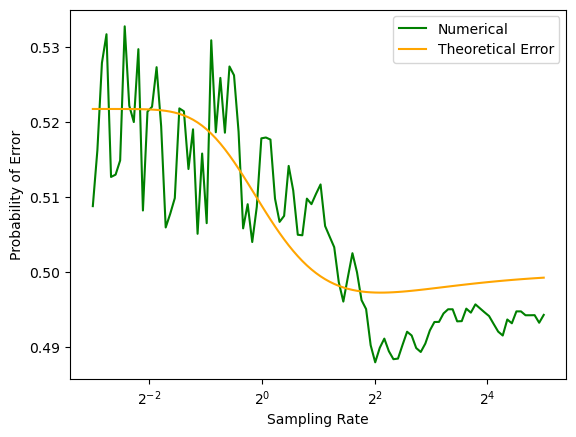

In [11]:
tperror = np.zeros(len(samp_rates))
numerical_errors = []
# For Now we will focus on Type I error  because H1 should always be preferred. 
for i in tqdm(np.arange(len(samp_rates))):
    sr = samp_rates[i]
    num = true_p1s[i][0,0] if true_p0s[i][0,0] > true_p1s[i][0,0] else true_p0s[i][0,0]
    num = true_p0s[i][0,0] 
    denum = true_p0s[i][0,0] + true_p1s[i][0,0]
    tperror[i] = num/denum


# Get the Numerical Erros
numerical_errors = (path_hyp_counts[:,0]) / (path_hyp_counts).sum(axis=1)

plt.plot(samp_rates, numerical_errors,color='green', label='Numerical')
plt.plot(samp_rates, tperror, color='orange', label='Theoretical Error')
plt.xscale('log',base=2)
plt.ylabel('Probability of Error')
plt.xlabel('Sampling Rate')
plt.legend()
plt.show()

## > 2 Step Paths:

This is for us to compute

$$
P(\epsilon| \Delta) 
    = \mathbb{E}\left[\frac{P^{(j)}_\Delta(\rho)\frac{1}{|\mathcal{H}|}}{P(\rho | \Delta)}\right]
$$

In [1]:
from sp_sims.detectors.pearsonneyman import *
import numpy as np
import sys
import matplotlib.pyplot as plt
import datetime
import argparse
from sklearn.metrics import roc_curve
from math import factorial
from scipy.linalg import expm
import sp_sims
from sp_sims.simulators.stochasticprocesses import *
from sp_sims.statistics.statistics import *
from sp_sims.estimators.algos import *
from IPython.display import clear_output
from sp_sims.sanitycheck.truebirthdeath import *
from sp_sims.utils.utils import *
import random
from tqdm.notebook import tqdm
from time import sleep
import time

In [2]:
importlib.reload(sp_sims.statistics.statistics)
importlib.reload(sp_sims.detectors.pearsonneyman)

<module 'sp_sims.detectors.pearsonneyman' from '/Users/rac716/Research/RL_RateOptimization/sp_sims/detectors/pearsonneyman.py'>

In [3]:
# We may change args here:
class Args:
  xres = 100
  length = 1000# Number of transitions in continuous chain 
  state_limit = 1#Inclusive
  init_state = 0
  num_samples =5
  detection_guesses =1000
args = Args()

In [4]:
def prob_of_path(path,  p0,p1):
    # Take two possible hypothesis
    num = 1
    denum = 1
    for i in range(len(path)-1):
        from_state = path[i]
        to_state = path[i+1]
        num  *= p0[from_state,to_state]
        denum *= p1[from_state,to_state]
    # Return the least preferred one
    return num if denum > num else denum

### Theoretical Error

In [5]:
# We want to calculate the average error probability for all paths
# We shouldn't be needing paths
from itertools import product

np.random.seed(0)
#np.random.seed(int(time.time()))
#num_steps = args.length
#num_states = args.state_limit+1
num_steps = args.num_samples
num_states = 2

states = np.arange(num_states)
samp_rates = np.logspace(-3,5,args.xres, base=2)
rates0 = {"lam": 4/10,"mu":12/10}
rates1 = {"lam": 100/10,"mu":122/10}

rates = [rates0,rates1]

tgm0 = np.array([[-rates0['lam'],rates0['lam']],[rates0['mu'],-rates0['mu']]])
tgm1 = np.array([[-rates1['lam'],rates1['lam']],[rates1['mu'],-rates1['mu']]])

hts, sts = ([],[])
last_times  = []
true_values = np.random.choice(2,args.detection_guesses)
# Generate The Tapes
for i in range(args.detection_guesses):
    roe = RaceOfExponentials(args.length,rates[true_values[i]],state_limit=args.state_limit)
    holdTimes_tape, state_tape = roe.generate_history(args.init_state)
    hts.append(holdTimes_tape)
    sts.append(state_tape)
    last_times.append(np.cumsum(holdTimes_tape)[-1])

# Preparation of True Probabilities
true_p0s = []
true_p1s = []
fixed_guesses = np.ones((len(samp_rates), args.detection_guesses))
# Crete all the *known* probability functions.
for srIdx, cur_samp_rate in enumerate(samp_rates):
    true_p0s.append(expm(tgm0*(1/cur_samp_rate)))
    true_p1s.append(expm(tgm1*(1/cur_samp_rate)))

# Generate
# TODO decrease memory consumption by only using iterators
paths = np.array(list(product(states, repeat=num_steps-1)))
paths = np.concatenate([np.repeat([[0]],repeats=paths.shape[0], axis=0), paths], axis=1)
probs = []

# Sum them up and that should be your probability 
for srIdx, cur_samp_rate in enumerate(samp_rates):
    probs.append(np.sum(np.apply_along_axis(prob_of_path, 1, paths, true_p0s[srIdx],true_p1s[srIdx])))

### Numerical/Experimental Errors

In [6]:
# Redo the testing experiments
import importlib

np.random.seed(0)
hts, sts = ([],[])
last_times  = []

base_samp_rate = samp_rates[-1]

for i in range(args.detection_guesses):
    roe = RaceOfExponentials(args.length,rates[true_values[i]],state_limit=args.state_limit)
    holdTimes_tape, state_tape = roe.generate_history(args.init_state)
    hts.append(holdTimes_tape); sts.append(state_tape)
    last_times.append(np.cumsum(holdTimes_tape)[-1])

# Go Over the Detection Guesses
guesses = np.zeros((len(samp_rates), args.detection_guesses))
min_length = np.inf
for i in tqdm(np.arange(args.detection_guesses)):
    
    # Prepare for Decimation: First sample with the quickest rate. -> Smallest Unit of Time Interval
    #sampled_tape = quick_sample(base_samp_rate, sts[i],hts[i])
    # Go Over the 
    for srIdx, cur_samp_rate in enumerate(samp_rates):
        # Fetch Values for Current Rate
        true_p0 = true_p0s[srIdx]
        true_p1 = true_p1s[srIdx]
        
        #LG: How many of the baseline intervals fit into the slow rate interval
        #decimateInterval = int(base_samp_rate/cur_samp_rate)
        #tmpSampTape = sampled_tape[0::decimateInterval]
        # If you use decimation you get a less accurate 
        ##tmpSampTape = quick_sample(cur_samp_rate, sts[i],hts[i])
        tmpSampTape, replicas = quick_sample_lessmem(cur_samp_rate, sts[i],hts[i], max_samples = args.num_samples)
        # Limit the Sample
        ############################################
        # Option 2 with limited number of samples ##
        ############################################
        #min_length = np.min([len(tmpS), min_length])# Debugging Stat

        ##limited_sampled_tape = tmpSampTape[0:args.num_samples]
        ##guesses[srIdx, i] = take_a_guess(limited_sampled_tape,true_p0, true_p1)
        guesses[srIdx, i] = multiplicity_guess(tmpSampTape,replicas, true_p0, true_p1)

num_negs = np.sum(true_values == 0)#TN + FP
num_pos = np.sum(true_values == 1)#TP + FN
#print("Min Length reached is ", min_length)

fprs,fnrs = ([],[])
hit_rates = []

for srIdx, cur_samp_rate in enumerate(samp_rates):
    guess = guesses[srIdx]
    hits_index = (true_values == guess)
    tp = (true_values[hits_index] == 1).sum()
    tn = (true_values[hits_index] == 0).sum()
    # False Positive and Negative Rates
    fprs.append((num_negs-tn)/(num_negs))
    fnrs.append((num_pos-tp)/(num_pos))# Type 2 Error
    num_hits = (true_values == guess).sum()
    hit_rates.append(num_hits/args.detection_guesses)
fprs = np.array(fprs)
fnrs = np.array(fnrs)
tot_error = fprs+ fnrs

  0%|          | 0/1000 [00:00<?, ?it/s]

Minimum Error is obtained at 11.039833162105994
This show that the summation of both errors is closer to monotonicity than having peaks.


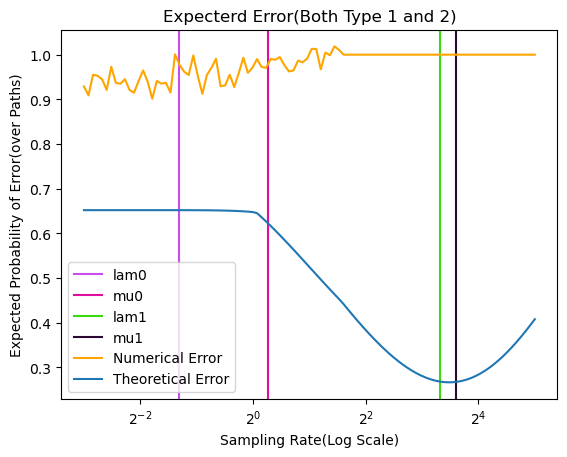

In [7]:
#meep = np.apply_along_axis(prob_of_path, 1, paths, true_p0s[srIdx],true_p1s[srIdx])
#print(len(meep))
#print(meep)
#plt.plot(samp_rates, hit_rates, color='red', label='Accuracy', alpha=0.2)
#plt.plot(samp_rates, fprs, color='green', label='Type 1 Error', alpha=0.2)
#plt.plot(samp_rates, fnrs, color='purple', label='Type 2 Error', alpha=0.2)
ratess = {"lam0":4/10,"mu0":12/10,"lam1":100/10,"mu1":122/10}
for k,v in ratess.items():
    plt.axvline(x=v,label=k,c=np.random.rand(3,))

plt.plot(samp_rates, tot_error, color='orange', label='Numerical Error')
plt.plot(samp_rates, probs, label='Theoretical Error')
plt.title('Expecterd Error(Both Type 1 and 2)')
print('Minimum Error is obtained at {}'.format(samp_rates[np.argmin(probs)]))
plt.xscale('log', base=2)
plt.legend()
plt.xlabel('Sampling Rate(Log Scale)')
plt.ylabel('Expected Probability of Error(over Paths)')
print('This show that the summation of both errors is closer to monotonicity than having peaks.')
plt.show()

In [ ]:
# Just Checking the Probability Per Hypothesis. 
# See If Probabilities Change:
p00_0s = np.array([p[0,0] for p in true_p0s])
p00_1s = np.array([p[0,0] for p in true_p1s])

# Numerical(Excellent this agrees)
plt.plot(samp_rates, path_hyp_counts[:,0]/totpath_hyp_counts[:,0], label="Emp_H0")

# Theoretical 
plt.plot(samp_rates, p00_0s, label="H_0")
plt.plot(samp_rates, p00_1s, label="H_1")
plt.plot(samp_rates, p00_0s/(p00_0s+p00_1s), label="H_1")
plt.legend()
plt.title("P(0,0) per Hypothesis")
plt.xscale('log',base=2)
plt.show()
# Clearym in our particular case H1 is superior than Hypothesis 0 for every single sampling rate. 

In [ ]:
for i,j in enumerate(samp_rates):
    clear_output(wait=True)
    print(fixed_fprs[i])
    print(fixed_guesses[i])
    print(true_p0s[i])
    print(true_p1s[i])
    sleep(0.1)

# RL-Oracle

Issue is the things that we were feeding to our previous model. We should feeed only the hypothesis(parameters) 
and then then we can generate a lot of paths from it and see how it does with the sampling rate it choses

In [7]:
import torch
import numpy as np
from torch import nn
import sp_sims
from sp_sims.simulators.stochasticprocesses import *
from sp_sims.statistics.statistics import *
import torch.optim as optim

from scipy.linalg import expm

import importlib
importlib.reload(sp_sims.simulators.stochasticprocesses)
importlib.reload(sp_sims.statistics.statistics)

<module 'sp_sims.statistics.statistics' from '/Users/rac716/Research/RL_RateOptimization/sp_sims/statistics/statistics.py'>

## Define the Model

In [8]:
from collections import deque, namedtuple
import torch.nn.functional as F
import random
class RNNContinuousPolicy(nn.Module):
    def __init__(self, num_params,hidden_size,samp_rate_max=32):
        super(RNNContinuousPolicy,self).__init__()
        #self.state_limit = num_states
        #self.fc1 = nn.Linear(num_params, hidden_size)
        #self.fc2 = nn.Linear(hidden_size, 1)
        self.samp_rate_max = samp_rate_max
        self.model = nn.Sequential(
            nn.Linear(num_params, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.ReLU(),
            nn.Linear(6, 1)
        )

    def forward(self, X):
        # Prpping
        #_,(hiddn,_) = self.rnn(X)
        #logit = self.fc2(F.relu(self.fc1(X)))
        logit = self.model(X)
        output = torch.sigmoid(logit)
        output_normalized = output*self.samp_rate_max
        return output_normalized
        # We are giving X as a 

# Critic Network
class Critic(nn.Module):
    def __init__(self, num_param, action_size, hidden_size):
        super(Critic, self).__init__()
        #self.fc1 = nn.Linear(num_param + action_size, hidden_size)
        #self.fc2 = nn.Linear(hidden_size, 1)
        self.model = nn.Sequential(
            nn.Linear(num_param+action_size, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.ReLU(),
            nn.Linear(6, 1)
        )

    def forward(self, states, action):# States are the paremeters
        #_,(h,_)  = self.rnn(mstates)
        x = torch.cat((states, action), dim=1)
        return self.model(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)*10
# Replay buffer

class ReplayBuffer:

    def __init__(self, buffer_size, batch_size, chain_length, num_states):
        self.chain_length = chain_length
        self.num_states = num_states
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "samp_rate", "errors" ])

    def add(self, state, samp_rate, errors):
        e = self.experience(state, samp_rate, errors)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states =  torch.empty((self.batch_size,2**2))# TODO Remove hard code to the number of entries in generator matrix

        # The states will be encoded as tensors
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.samp_rate for e in experiences if e is not None])).float()
        errors = torch.from_numpy(np.vstack([e.errors for e in experiences if e is not None])).float()

        return states, actions, errors

    def __len__(self):
        return len(self.memory)

## Setup

In [ ]:
# Create the Datasets
# We may change args here:
class Args2:
  xres = 100
  length = 1000# Number of transitions in continuous chain 
  state_limit = 1#Inclusive # DO NOT CHANGE, Architecture can't take it yet
  init_state = 0
  num_samples =5
  batch_size =128
  poptimizer_lr = 1e-2
  coptimizer_lr = 1e-2
  clipping_limit = 64 # Sampling rate no Bigger than this. 
  detection_guesses =10000
  num_epochs = 1000
  num_replay_samples = 1 # How many batches do we sample at a time to learn 
# Data Class
class MetaState:
  states: list
  holding_times: list
  def __init__(self,states, holding_times):
    self.states = states
    self.holding_times = holding_times

args2 = Args2()

In [ ]:
def get_errors(sampled_tapes, probs, true_hyps):
    # Clean it up 
    p0, p1 = probs
    # Take our guesses
    guesses = np.array([take_a_guess(tape, p0[i],p1[i]) for i,tape in enumerate(sampled_tapes)])
    errors = -1*np.array(true_hyps != guesses)
    return errors


def take_a_guess(tape, p0,p1):
    num = 0
    denum = 0
    for i in range(len(tape)-1):
        from_state = tape[i]
        to_state = tape[i+1]
        num += np.log(p0[from_state,to_state])
        denum += np.log(p1[from_state,to_state])
    return 0 if num > denum else 1

## Bootstrap the Replay Buffer

In [ ]:
# Replay buffer stores (s,a,r,s',d)
# Meaning the Hidden State we se the action we took and the corresponding reward
def populate_replay_buffer(rbuffer,num_of_examples, guesses_per_rate = 64):
    
    ## Start By Generating States
    # TODO: Maybe Try Uniform
    # Null Hyp
    #rates0 = np.random.chisquare(df=2, size =(num_of_examples,2))
    #rates0[:,1] = np.sum(rates0,axis=1) # So that mu > lam
    # Alter Hyp
    #rates1 = np.random.chisquare(df=2, size =(num_of_examples,2))
    #rates1[:,1] = np.sum(rates1,axis=1) # So that mu > lam
    rates0,rates1 = np.zeros((num_of_examples,2)), np.zeros((num_of_examples,2))
    rates0[:,0] = np.random.normal(4/10, 0.1,num_of_examples)
    rates0[:,1] = np.random.normal(12/10,0.1,num_of_examples)
    # Make Sure lam > mu
    idcs = rates0[:,0] > rates0[:,1] 
    rates0[idcs, 1] = rates0[idcs,0] + 1
    #rates0[torch.chat(idcs, torch.ones((num_of_examples,1)))] = rates0[idcs:0] + 1

    rates1[:,0] = np.random.normal(100/10,1, num_of_examples)
    rates1[:,1] = np.random.normal(122/10,1, num_of_examples)
    idcs = rates1[:,0] > rates1[:,1] 
    rates1[idcs, 1] = rates1[idcs,0] + 1

    rates0 = rates0.clip(0.1,None)
    rates1 = rates1.clip(0.1,None)


    rates = [rates0,rates1]

    # Get Errors  # ACTIONS
    smp_rates = np.random.uniform(0,2**5, num_of_examples) # Actions
    errors = [0]*len(smp_rates)# Amount of errors per action

    # Calculate Errors
    for i in range(rates0.shape[0]):# For Every State-Action
        true_hyps = np.random.choice(2,guesses_per_rate)
        
        p0 = expm((1/smp_rates[i])*np.array([[-rates0[i,0],rates0[i,0]],[rates0[i,1],-rates0[i,1]]]))# 0=lam, 1=mu
        p1 = expm((1/smp_rates[i])*np.array([[-rates1[i,0],rates1[i,0]],[rates1[i,1],-rates1[i,1]]]))

        for j in range(guesses_per_rate): # Sample a bunch of paths
            roe = RaceOfExponentials(args2.length,rates[true_hyps[j]][i],state_limit=args2.state_limit)
            holdTimes_tape, state_tape = roe.generate_history(args2.init_state)
            # Action Performance(Sampling At Rate)
            tape = quick_sample(smp_rates[i],state_tape,holdTimes_tape,args2.num_samples)

            # Get the corresponding Losses
            errors[i] += take_a_guess(tape, p0,p1)  != true_hyps[j]

    #errors = 10*(np.array(errors) / guesses_per_rate)
    #errors = np.array(errors) / guesses_per_rate

    #plt.scatter(smp_rates, errors,s=10)
    #plt.ylim((0,1))
    #plt.show()
    #exit()

    for i in range(num_of_examples):
        rbuffer.add(list(rates0[i])+list(rates1[i]), smp_rates[i],errors[i])

def add_actions_to_buffer(buffer, states, actions, guesses_per_rate =64):
    errors = [0]*len(actions)# Amount of errors per action

    for i in range(actions.shape[0]):# For Every State-Action
        true_hyps = np.random.choice(2,guesses_per_rate)
        
        p0 = expm((1/actions[i])*np.array([[-states[i,0],states[i,0]],[states[i,1],-states[i,1]]]))# 0=lam, 1=mu
        p1 = expm((1/actions[i])*np.array([[-states[i,2],states[i,2]],[states[i,3],-states[i,3]]]))

        for j in range(guesses_per_rate): # Sample a bunch of paths
            offset = true_hyps[j]*1
            roe = RaceOfExponentials(args2.length,states[i,offset:offset+2].detach(),state_limit=args2.state_limit)
            holdTimes_tape, state_tape = roe.generate_history(args2.init_state)
            # Action Performance(Sampling At Rate)
            tape = quick_sample(actions[i],state_tape,holdTimes_tape,args2.num_samples)

            # Get the corresponding Losses
            errors[i] += take_a_guess(tape, p0,p1)  != true_hyps[j]

    errors = np.array(errors) / guesses_per_rate

    for i in range(states.shape[0]):
        buffer.add(list(states[i,:]), actions[i], errors[i])

Activating Apple Metal


  0%|          | 0/1000 [00:00<?, ?it/s]

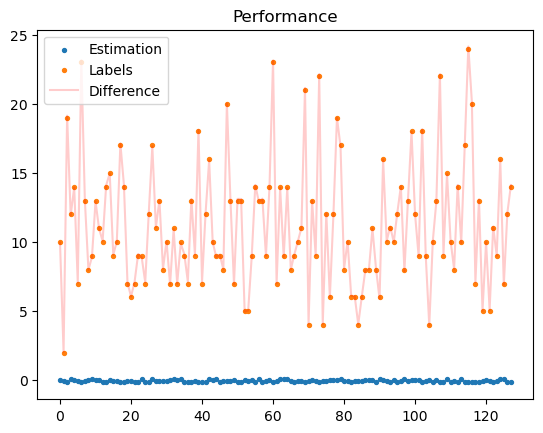

/Users/rac716/miniforge3/envs/rs39/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:315: RuntimeWarning: overflow encountered in cosh
  coshMu = np.cosh(mu)
/Users/rac716/miniforge3/envs/rs39/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:318: RuntimeWarning: overflow encountered in sinh
  sinchMu[mask] = np.sinh(mu[mask]) / mu[mask]
/Users/rac716/miniforge3/envs/rs39/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:320: RuntimeWarning: invalid value encountered in multiply
  eA[..., [0], [0]] = eApD2 * (coshMu + AmD2*sinchMu)
/Users/rac716/miniforge3/envs/rs39/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:321: RuntimeWarning: invalid value encountered in multiply
  eA[..., [0], [1]] = eApD2 * a2 * sinchMu
/Users/rac716/miniforge3/envs/rs39/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:322: RuntimeWarning: invalid value encountered in multiply
  eA[..., [1], [0]] = eApD2 * a3 * sinchMu
/Users/rac716/miniforge3/envs/rs39/lib/python3.9/site-packages/scipy

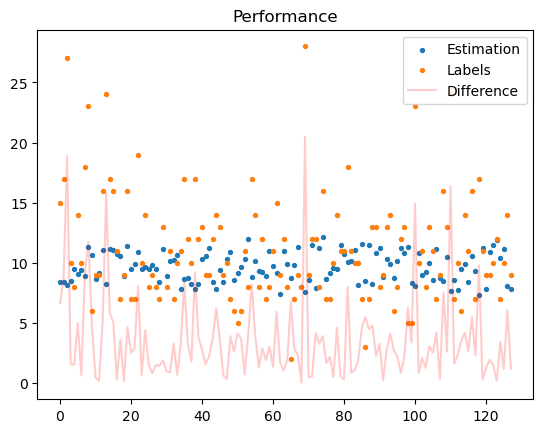

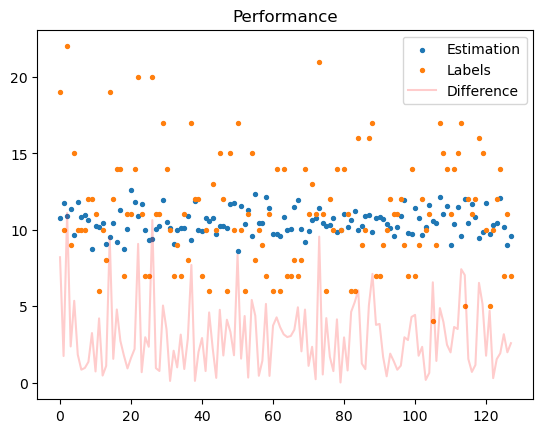

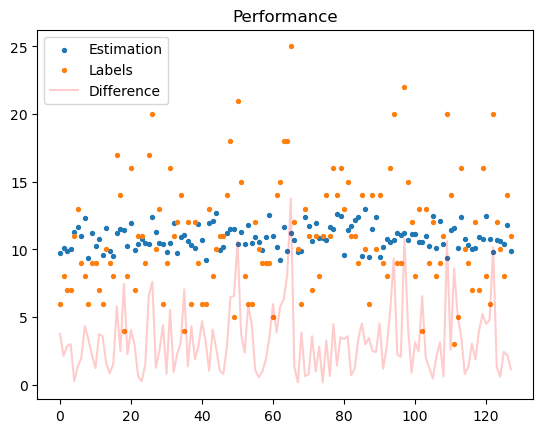

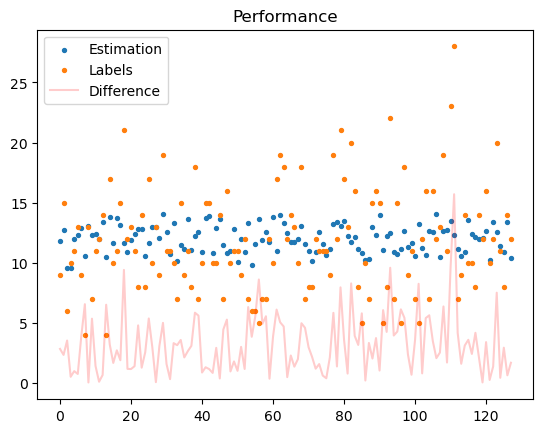

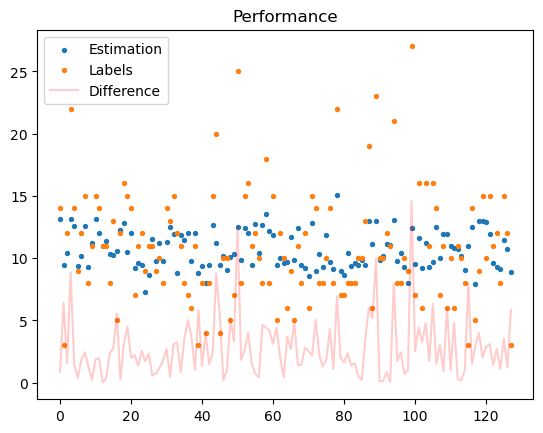

In [12]:
# Start Working on the Model
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from tqdm.auto import tqdm

if torch.backends.mps.is_available():
    print("Activating Apple Metal")
    device = torch.device("mps")
else:
    device = torch.device("cpu")

class PolicyLoss(nn.Module):
    def __init__(self):
        super(PolicyLoss, self).__init__()

    def forward(self, estimation):
        return torch.mean(estimation)

# TODO remove hard code 
policy = RNNContinuousPolicy(2*2,hidden_size=16).to(device)
critic = Critic(2*2, 1, 16).to(device)
poptimizer = optim.Adam(policy.parameters(), lr = args2.poptimizer_lr)
coptimizer = optim.Adam(critic.parameters(), lr = args2.coptimizer_lr)

rbuffer = ReplayBuffer(256,args2.batch_size, args2.length,args2.state_limit+1)
populate_replay_buffer(rbuffer,args2.batch_size)
# We have Enough Data to Start Sampling and Exploring With 
epochs = tqdm(range(args2.num_epochs),leave=True)
qvalue_loss = []
policyExpectedReward = []
val_srate = []
qlosses,plosses = [],[]
q_losscrit = nn.MSELoss()
p_losscrit = PolicyLoss()
for e in epochs:
    poptimizer.zero_grad()
    coptimizer.zero_grad()
    ########################################
    # Collect Data
    ########################################
    # This loop will generate paths with the existing policy 
    # Sample Transitions used for learnign
    states, actions, rewards = rbuffer.sample()
    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)

    # Get Rates
    y = rewards
    # Since We We are Doing Accuracy We have to create 
    ########################################
    # Update Networks
    ########################################
    # Calculate the Losses
    #loss_Q = (1/args2.batch_size)*torch.sum(torch.pow(critic(states, actions) - y,2))
    #loss_P = (1/args2.batch_size)*torch.sum(critic(states, policy(states)))
    loss_Q = q_losscrit(critic(states,actions), y)
    loss_P = p_losscrit(critic(states,policy(states)))

    # Learn 
    loss_Q.backward()
    loss_P.backward()
    poptimizer.step()
    coptimizer.step()

    qlosses.append(loss_Q.item())
    plosses.append(loss_P.item())

    # In this one particular case we have a single point that is global max so it would be
    # best to use optimized policy to do some exploration 
    qvalue_loss.append(loss_Q.item())
    policyExpectedReward.append(loss_P.item())

    # Validate with a known global min:
    validation_input = torch.tensor([[4/10,12/10,100/10,122/10]]).to(device)
    policy.eval()
    with torch.no_grad():
        val_srate.append(float(policy(validation_input).squeeze(-1).item()))
    policy.train()

    # Lets check performance 
    if e % 50 == 0:
        plt.clf()
        val = critic(states,actions).cpu().detach()
        plt.scatter(range(128), val, label='Estimation',s=8)
        plt.scatter(range(128), y.cpu(), label='Labels',s=8)
        plt.plot(range(128), np.abs(val-y.cpu()), label='Difference', color='red',alpha=0.2)
        plt.title('Performance')
        plt.legend()
        plt.show()
    
    # Lets look at the weights acrooss the network 
    epoch_description = ""

    for name, param in critic.named_parameters():
        epoch_description += "Parameter {} norm is {:.3f}\n".format(name, torch.norm(param)**2)

    epoch_description += 'Val Samp Rate {}, Loss_Q {} and loss_P {}'.format(val_srate[-1], np.mean(qlosses), np.mean(plosses))

    epochs.set_description(epoch_description)

    ## Prep for Next Iteration
    # Keep On Adding More Stuff to buffer to learn from 
    #add_actions_to_buffer(rbuffer, states.cpu(), actions.cpu())

    # Don't over populate the buffer
    if np.random.choice([0,1],1,p=[0.40,0.60]) == 0:
        populate_replay_buffer(rbuffer, args2.batch_size)
    #populate_replay_buffer(rbuffer, args2.batch_size)
    


In [ ]:
critic.eval()
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(2,2)

axs00 = fig.add_subplot(gs[0,0])
axs00.set_title('Learning Error Rates')
axs00.plot(range(len(qvalue_loss)),qvalue_loss,label="Value Estimation Loss")
axs00.legend()

axs01 = fig.add_subplot(gs[0,1])
axs01.set_title('Training Values')
axs01.axhline(y=11.03, label="Optimal Rate", color="Red")
axs01.plot(range(len(policyExpectedReward)),policyExpectedReward,label="Expected Policy Error")
axs01.plot(range(len(val_srate)),val_srate,label="Validation Rate")
axs01.legend()

critic_a = torch.tensor(samp_rates).view(-1,1).to(torch.float32).to(device)
critic_s = torch.tensor([4/10,12/10,100/10,122/10]).repeat(len(samp_rates),1).to(torch.float32).to(device)
critic_y = critic(critic_s,critic_a).cpu().detach()/64

# Printed Estimated Values 
axs10 = fig.add_subplot(gs[1,:])
axs10.set_title('Q Across Validation States')
axs10.plot(samp_rates, critic_y, label='Estimated Error Rate')
axs10.plot(samp_rates, probs, label='True Error Rate')
axs10.set_xscale('log', base=2)

#fig.delaxes(fig.axes[-1])

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
inputo = torch.tensor([[4/10,12/10,100/10,122/10]])
policy(inputo)

In [ ]:
# Runtthe Model 
states, a, rewards = rbuffer.sample()
rates = policy(states)
print("Rates Selected are :",rates)

#P(error | path, \Deleta)
tperror = np.zeros(len(samp_rates))
bloop = []
numerical_errors = []
# For Now we will focus on Type I error  because H1 should always be preferred. 
for i in tqdm(np.arange(len(samp_rates))):
    sr = samp_rates[i]
    #num = true_p1s[i][0,0] if true_p0s[i][0,0] > true_p1s[i][0,0] else true_p0s[i][0,0]
    num = true_p0s[i][0,0] 
    denum = true_p0s[i][0,0] + true_p1s[i][0,0]
    tperror[i] = num/denum


# Get the Numerical Erros
plt.plot(samp_rates, numerical_errors,color='green')
plt.plot(samp_rates, tperror, color='orange')
plt.xscale('log',base=2)
#plt.ylim((0,1))
plt.show()

